# DALL·E mini - Inference pipeline

*Generate images from a text prompt*

<img src="https://github.com/borisdayma/dalle-mini/blob/main/img/logo.png?raw=true" width="200">

This notebook illustrates [DALL·E mini](https://github.com/borisdayma/dalle-mini) inference pipeline.

Just want to play? Use [the demo](https://huggingface.co/spaces/flax-community/dalle-mini) (temporarily in beta on Huging Face Spaces but soon to be open to all).

For more understanding of the model, refer to [the report](https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-mini--Vmlldzo4NjIxODA).

## Install dependencies

In [1]:
!pip install -q transformers flax
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git  # VQGAN model in JAX
!git clone https://github.com/borisdayma/dalle-mini  # Model files
%cd dalle-mini/

You should consider upgrading via the '/opt/anaconda3/envs/saas/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/anaconda3/envs/saas/bin/python -m pip install --upgrade pip' command.
fatal: le chemin de destination 'dalle-mini' existe déjà et n'est pas un répertoire vide.
/Users/mac/Desktop/sideProjects/saas-proj/dalle-mini


In [2]:
from dalle_mini.model import CustomFlaxBartForConditionalGeneration
from transformers import BartTokenizer
import jax
import random
from tqdm.notebook import tqdm, trange

ModuleNotFoundError: No module named 'jax'

In [3]:
# make sure we use compatible versions
DALLE_REPO = 'flax-community/dalle-mini'
DALLE_COMMIT_ID = '4d34126d0df8bc4a692ae933e3b902a1fa8b6114'

In [4]:
# set up tokenizer and model
tokenizer = BartTokenizer.from_pretrained(DALLE_REPO, revision=DALLE_COMMIT_ID)
model = CustomFlaxBartForConditionalGeneration.from_pretrained(DALLE_REPO, revision=DALLE_COMMIT_ID)

NameError: name 'BartTokenizer' is not defined

In [5]:
# set a prompt
prompt = 'picture of a waterfall under the sunset'

In [6]:
# tokenize the prompt
tokenized_prompt = tokenizer(prompt, return_tensors='jax', padding='max_length', truncation=True, max_length=128)
tokenized_prompt

{'input_ids': DeviceArray([[    0, 37587,     9,    10, 35076,   223,     5, 18820,
                  2,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
      

Notes:

* `0`: BOS, special token representing the beginning of a sequence
* `2`: EOS, special token representing the end of a sequence
* `1`: special token representing the padding of a sequence when requesting a specific length

In [7]:
n_predictions = 8

# create random keys
seed = random.randint(0, 2**32-1)
key = jax.random.PRNGKey(seed)
subkeys = jax.random.split(key, num=n_predictions)
subkeys

DeviceArray([[ 468042244,  997916197],
             [3903679757, 1522464877],
             [3442231027, 1743683175],
             [4157549494, 3930093013],
             [1373639433, 1687308541],
             [1053458820, 1394460682],
             [ 208836702, 3268773546],
             [ 958610539, 3448353880]], dtype=uint32)

In [8]:
# generate sample predictions
encoded_images = [model.generate(**tokenized_prompt, do_sample=True, num_beams=1, prng_key=subkey) for subkey in tqdm(subkeys)]
encoded_images[0]

  0%|          | 0/8 [00:00<?, ?it/s]

FlaxSampleOutput([('sequences',
                   DeviceArray([[16384, 11456,  8447,  6172, 12062,  6172,  2528, 14447,
                                  6172, 14447,  6808,  6242, 15945,  6243,  8770, 12062,
                                  8447, 16147, 11591, 15729,  9010,   601,  6805,  1811,
                                 11591,   601, 14793,  8888,  5908,  2683,  2523,  2428,
                                  6172, 16147,  1811,  6805,  1811, 11591,   601,  2528,
                                 14447,  9325,  6328,  7226, 10890,  4942, 11594, 11725,
                                 11196, 11196,  2528,  1811,  1052,  2528,  2528, 10689,
                                   774,  6172, 11665,  7927,  4868, 14319,  6058,  5772,
                                 11196,  6172, 10689, 12062,  8173, 13291, 14164,  2528,
                                  4945,  5772,  4395,  6060,  4159, 14319,  4590,  3379,
                                 14247, 15187, 14164,  7771, 15187, 10508,  81

The first token (`16384`) is a special token representing the start of a sequence in the decoder (not part of the image codebook).

In [9]:
# remove first token (BOS)
encoded_images = [img.sequences[..., 1:] for img in encoded_images]
encoded_images[0]

DeviceArray([[11456,  8447,  6172, 12062,  6172,  2528, 14447,  6172,
              14447,  6808,  6242, 15945,  6243,  8770, 12062,  8447,
              16147, 11591, 15729,  9010,   601,  6805,  1811, 11591,
                601, 14793,  8888,  5908,  2683,  2523,  2428,  6172,
              16147,  1811,  6805,  1811, 11591,   601,  2528, 14447,
               9325,  6328,  7226, 10890,  4942, 11594, 11725, 11196,
              11196,  2528,  1811,  1052,  2528,  2528, 10689,   774,
               6172, 11665,  7927,  4868, 14319,  6058,  5772, 11196,
               6172, 10689, 12062,  8173, 13291, 14164,  2528,  4945,
               5772,  4395,  6060,  4159, 14319,  4590,  3379, 14247,
              15187, 14164,  7771, 15187, 10508,  8173, 14447,  1495,
              15187, 13183,  1363, 12566,  6606,  9355,  5772,  7504,
               6243, 13157,  5314, 13293, 12509, 10508,  6805, 15366,
              13157, 12823,  1363,   217, 12927, 14853,  3742,  6243,
              13291,

The generated images are now represented by 256 tokens.

In [10]:
encoded_images[0].shape

(1, 256)

## Decode images

The generated images need to be decoded with `flax-community/vqgan_f16_16384`.

In [11]:
from vqgan_jax.modeling_flax_vqgan import VQModel
import numpy as np
from PIL import Image

In [12]:
# make sure we use compatible versions
VQGAN_REPO = 'flax-community/vqgan_f16_16384'
VQGAN_COMMIT_ID = '90cc46addd2dd8f5be21586a9a23e1b95aa506a9'

In [13]:
# set up VQGAN
vqgan = VQModel.from_pretrained(VQGAN_REPO, revision=VQGAN_COMMIT_ID)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/304M [00:00<?, ?B/s]

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


In [14]:
# decode images
decoded_images = [vqgan.decode_code(encoded_image) for encoded_image in tqdm(encoded_images)]
decoded_images[0]

  0%|          | 0/8 [00:00<?, ?it/s]

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


DeviceArray([[[[-4.40440997e-02,  8.14338494e-03, -2.15728506e-02],
               [-3.57139967e-02,  2.49534212e-02, -2.08981559e-02],
               [-1.65934004e-02,  1.97451226e-02,  5.41299582e-04],
               ...,
               [ 5.18753380e-03,  2.03122646e-02,  3.17566693e-02],
               [-1.20117180e-02,  8.19277484e-03,  1.09646395e-02],
               [-7.87825510e-03,  1.64659135e-02,  1.93124712e-02]],

              [[-2.20926367e-02,  4.14428525e-02,  2.06310302e-03],
               [-2.94255167e-02,  2.19032392e-02, -1.01268142e-02],
               [-1.60111189e-02,  2.63412558e-02,  1.08484924e-02],
               ...,
               [ 9.95814800e-04,  1.98801309e-02,  3.45958620e-02],
               [-7.26714730e-04,  2.41140388e-02,  2.42092013e-02],
               [-5.57281077e-04,  2.15079673e-02,  3.16767991e-02]],

              [[-2.66274773e-02,  3.44300382e-02,  1.79609656e-02],
               [-1.09012499e-02,  3.58636118e-02, -5.28866053e-03],
    

In [15]:
# normalize images
clipped_images = [img.squeeze().clip(0., 1.) for img in decoded_images]

In [16]:
# convert to image
images = [Image.fromarray(np.asarray(img * 255, dtype=np.uint8)) for img in clipped_images]

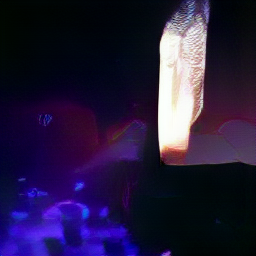

In [17]:
# display an image
images[0]

## Rank images with CLIP

We use `openai/clip-vit-base-patch32` to rank generated images against the prompt.

In [18]:
from transformers import CLIPProcessor, FlaxCLIPModel

In [19]:
# set up model and processor
clip = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Downloading:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/862k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


The CLIP processor tokenizes text and pre-processes images (resize to 224x224 and normalize) as required per the CLIP model.

In [20]:
# evaluate scores
inputs = processor(text=prompt, images=images, return_tensors='np')
logits = clip(**inputs).logits_per_image
scores = jax.nn.softmax(logits, axis=0).squeeze()  # normalize and sum all scores to 1

Prompt: picture of a waterfall under the sunset

Score: 0.7044008374214172


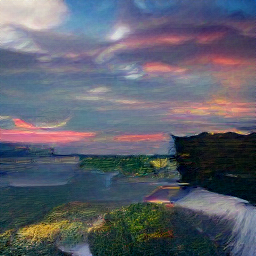


Score: 0.2350580394268036


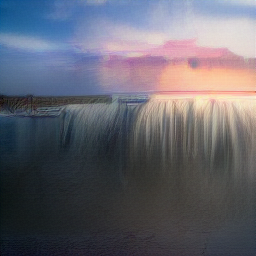


Score: 0.035456180572509766


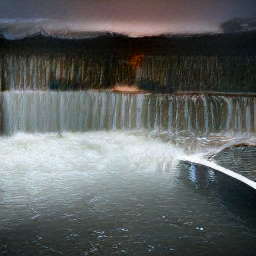


Score: 0.014829187653958797


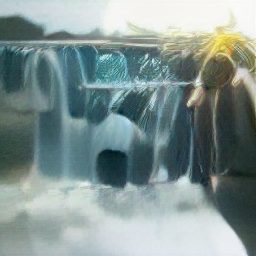


Score: 0.006640212144702673


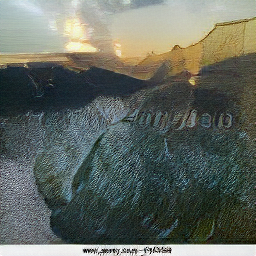


Score: 0.0034919320605695248


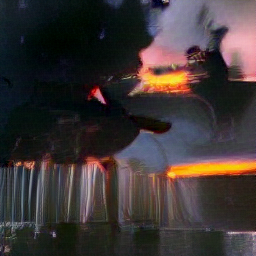


Score: 7.128562720026821e-05


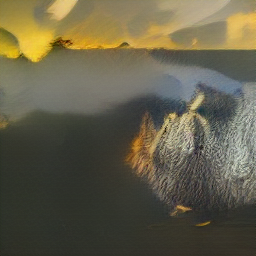


Score: 5.233553747530095e-05


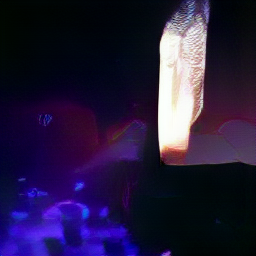

In [21]:
# rank images by score
print(f'Prompt: {prompt}\n')
for idx in scores.argsort()[::-1]:
    print(f'Score: {scores[idx]}')
    display(images[idx])
    print()

## Trasnform generated images into video

In [30]:
len(images)

8

In [31]:
type(images[0])

PIL.Image.Image

In [37]:
# Importing Image module from PIL package 
#from PIL import Image 
#import PIL 
  
# creating a image object (main image) 
#im1 = Image.open(r"C:\Users\System-Pc\Desktop\flower1.jpg") 

for i, img in enumerate(images):
  # save a image using extension
  im1 = img.save("/content/dalle-mini/test_imgs/" + str(i) + ".png")

- All code rights reserved to : https://www.codespeedy.com/convert-audio-to-video-using-static-images-in-python/
- Music mp3 taken from : https://freemp3cloud.com/en/ [Ludwig van Beethoven by К Элизе]
- Another website for free mp3: https://www.bensound.com/royalty-free-music/3

In [34]:
!pip install mutagen
!pip install moviepy

     |████████████████████████████████| 218 kB 16.0 MB/s 


In [38]:
# Loading all the packages required
from mutagen.mp3 import MP3
from PIL import Image
from pathlib import Path
from moviepy import editor

'''
Creating class MP3ToMP4 which contains methods to convert
an audio to a video using a list of images.
'''


class MP3ToMP4:

    def __init__(self, folder_path, audio_path, video_path_name):
        """
        :param folder_path: contains the path of the root folder.
        :param audio_path: contains the path of the audio (mp3 file).
        :param video_path_name: contains the path where the created
                                video will be saved along with the
                                name of the created video.
        """
        self.folder_path = folder_path
        self.audio_path = audio_path
        self.video_path_name = video_path_name

        # Calling the create_video() method.
        self.create_video()

    def get_length(self):
        """
        This method reads an MP3 file and calculates its length
        in seconds.

        :return: length of the MP3 file
        """
        song = MP3(self.audio_path)
        return int(song.info.length)

    def get_images(self):
        """
        This method reads the filenames of the images present
        in the folder_path of type '.png' and stores it in the
        'images' list.

        Then it opens the images, resizes them and appends them
        to another list, 'image_list'

        :return: list of opened images
        """
        path_images = Path(self.folder_path)
        images = list(path_images.glob('*.png'))
        image_list = list()
        for image_name in images:
            image = Image.open(image_name).resize((800, 800), Image.ANTIALIAS)
            image_list.append(image)
        return image_list

    def create_video(self):
        """
        This method calls the get_length() and get_images()
        methods internally. It then calculates the duration
        of each frame. After that, it saves all the opened images
        as a gif using the save() method. Finally it calls the
        combine_method()

        :return: None
        """
        length_audio = self.get_length()
        image_list = self.get_images()
        duration = int(length_audio / len(image_list)) * 1000
        image_list[0].save(self.folder_path + "temp.gif",
                           save_all=True,
                           append_images=image_list[1:],
                           duration=duration)

        # Calling the combine_audio() method.
        self.combine_audio()

    def combine_audio(self):
        """
        This method attaches the audio to the gif file created.
        It opens the gif file and mp3 file and then uses
        set_audio() method to attach the audio. Finally, it
        saves the video to the specified video_path_name

        :return: None
        """
        video = editor.VideoFileClip(self.folder_path + "temp.gif")
        audio = editor.AudioFileClip(self.audio_path)
        final_video = video.set_audio(audio)
        final_video.write_videofile(self.video_path_name, fps=60)


if __name__ == '__main__':
    # Taking the input for the paths of the variables mentioned below.
    folder_path = input("Enter the Path of the Folder containing Images: ")
    audio_path = input("Enter the Path of the MP3 file: ")
    video_path_name = input("Enter the Path followed by name of the Video to be created: ")

    # Invoking the parameterized constructor of the MP3ToMP4 class.
    MP3ToMP4(folder_path, audio_path, video_path_name)

Enter the Path of the Folder containing Images: /content/dalle-mini/test_imgs
Enter the Path of the MP3 file: /content/dalle-mini/test_music/Ludwig_van_Beethoven.mp3
Enter the Path followed by name of the Video to be created: /content/dalle-mini/test2.mp4
[MoviePy] >>>> Building video /content/dalle-mini/test2.mp4
[MoviePy] Writing audio in test2TEMP_MPY_wvf_snd.mp3


100%|██████████| 4454/4454 [00:08<00:00, 539.03it/s]

[MoviePy] Done.
[MoviePy] Writing video /content/dalle-mini/test2.mp4



100%|█████████▉| 10560/10561 [02:23<00:00, 73.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/dalle-mini/test2.mp4 



## Leverage JAX for faster inference

[JAX](https://github.com/google/jax) uses XLA to compile code to GPU/TPU, leading to faster inference.

Even with only 1 GPU, we can benefit from impressive speedups, even more after first inference (where the compilation happens).

In [22]:
from functools import partial
from flax.training.common_utils import shard
from flax.jax_utils import replicate

In [23]:
# check we can access TPU's or GPU's
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [24]:
# replicate parameters on all devices
dalle_params = replicate(model.params)
vqgan_params = replicate(vqgan.params)

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:391: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:378: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "


In [25]:
# one set of inputs per device
prompt = ['picture of a waterfall under the sunset'] * jax.device_count()

In [26]:
# tokenize prompts and shard them across available devices
tokenized_prompt = tokenizer(prompt, return_tensors='jax', padding='max_length', truncation=True, max_length=128).data
tokenized_prompt = shard(tokenized_prompt)

We use `pmap` to compile the functions with XLA and perform operations in parallel on multiple devices.

In [27]:
# parallelize and compile functions

# function to generate encoded images
@partial(jax.pmap, axis_name="batch")
def p_generate(tokenized_prompt, key, params):
    return model.generate(
        **tokenized_prompt,
        do_sample=True,
        num_beams=1,
        prng_key=key,
        params=params
    )

# function to decode images
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

In [28]:
# generate images with compiled functions
n_predictions = 8
images = []

for i in trange(n_predictions // jax.device_count()):
    key, *subkeys = jax.random.split(key, jax.device_count() + 1)
    subkeys = jax.numpy.stack(subkeys)

    encoded_images = p_generate(tokenized_prompt, subkeys, dalle_params)
    encoded_images = encoded_images.sequences[..., 1:]

    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0., 1.).reshape((-1, 256, 256, 3))

    for img in decoded_images:
        images.append(Image.fromarray(np.asarray(img * 255, dtype=np.uint8)))

  0%|          | 0/8 [00:00<?, ?it/s]

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


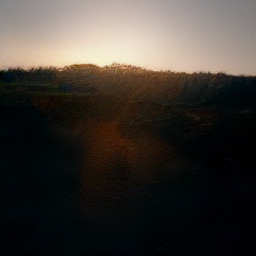

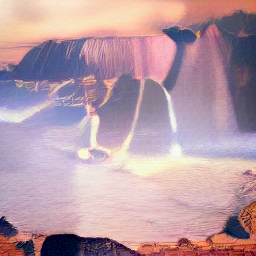

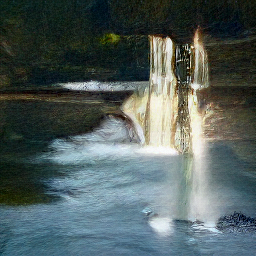

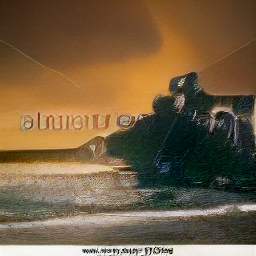

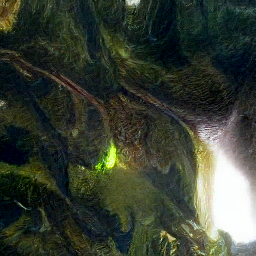

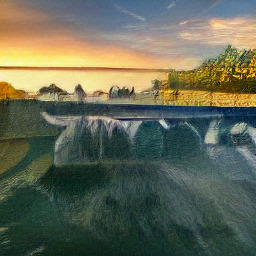

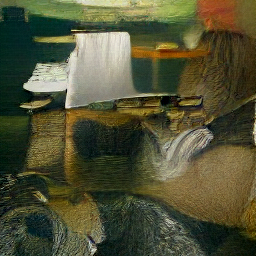

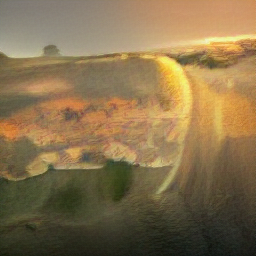

In [29]:
for img in images:
    display(img)
    print()